In [1]:
import brighteyes_ism.analysis.APR_lib as apr
import brighteyes_ism.analysis.Graph_lib as gr
import h5py
import numpy as np 
import brighteyes_flim as flim
import brighteyes_ism.analysis.Tools_lib as tools
import brighteyes_ism.dataio.mcs as mcs
import matplotlib.pyplot as plt
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift
from tqdm import tqdm

In [4]:
h = h5py.File(r"C:\Users\fdelbufalo\Desktop\images\G3BP1_29_05_2024","r")
print(h.keys())
img = h["dataset_1"]
print(img.shape)

<KeysViewHDF5 ['dataset_1']>
(512, 512, 260, 25)


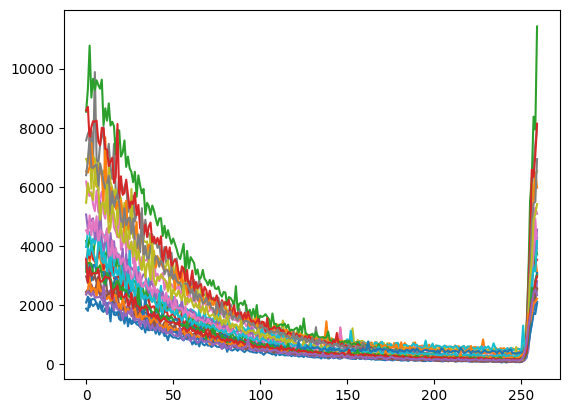

In [5]:
bins = np.sum(img, axis=(0,1))
plt.figure()
for i in range(bins.shape[-1]):
    plt.plot(bins[:, i])

In [6]:
img_sum = np.sum(img, axis=-2)
img_int = np.asarray(img_sum)
img_int.shape

(512, 512, 25)

In [7]:
pxs = 146         # pixel size of the ISM dataset converted in nm (metadata saves the pixel size in micrometers)
upsampling_factor = 10        # upsampling factor to improve accuracy in simulation
Nch = img_int.shape[-1]
reference = Nch // 2  #the reference image for the shift vectors extraction is the central one

shift_vectors, _ = apr.ShiftVectors(img_int, upsampling_factor, reference, filter_sigma=1)
shift_vectors *= pxs # we convert the shifts from pixels units to nm

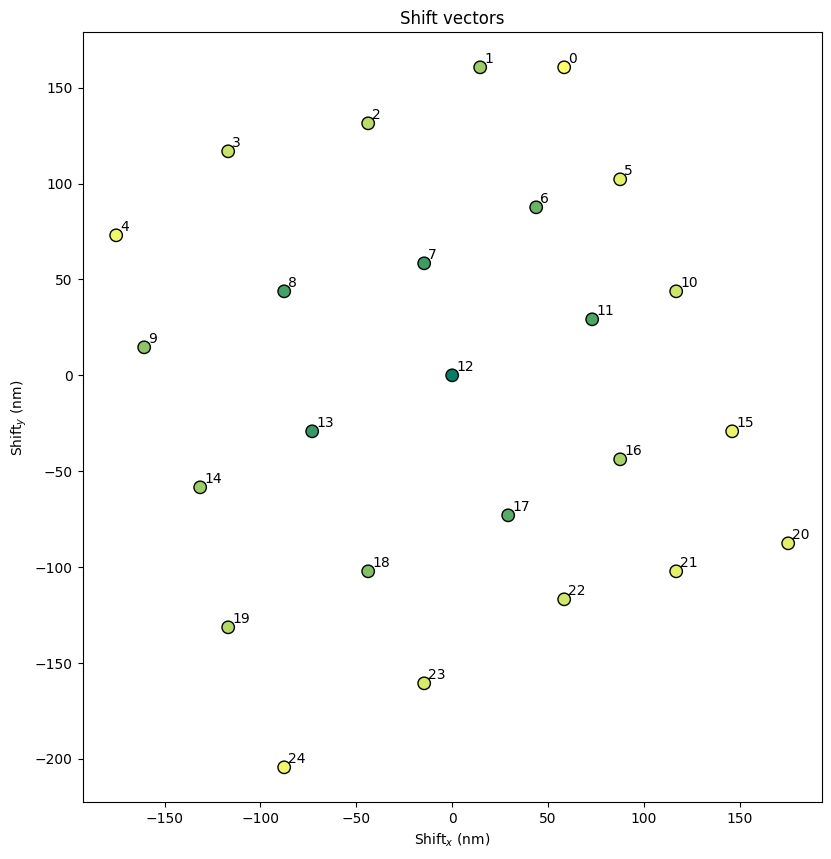

In [8]:
fig_3, ax_3 = plt.subplots(figsize = (10, 10))

fing = tools.fingerprint(img_int)
_ = gr.PlotShiftVectors(shift_vectors, color=fing, fig = fig_3, ax = ax_3)

In [9]:
import brighteyes_ism.simulation.PSF_sim as sim  
ups = 10
exPar = sim.simSettings()
exPar.na = 1.4   # numerical aperture
exPar.wl = 488   # wavelength [nm]
exPar.gamma = 45 # parameter describing the light polarization
exPar.beta = 90  # parameter describing the light polarization
exPar.n = 1.5    # refractive index of immersion medium
exPar.mask_sampl = 50       #sampling points of the phase mask in simulation

emPar = exPar.copy()
emPar.wl = 510   # wavelength [nm]

grid = sim.GridParameters()
grid.N = 5  # number of elements for each axis of the detector array, assumed squared
grid.pxpitch = 75e3  # detector pixel pitch [nm]
grid.pxdim = 50e3  # detector pixel size [nm]
grid.Nz = 2
grid.pxsizex = pxs  # pixel size of acquisition [nm]
grid.pxsizez = 551  # 'ToFind'


In [10]:
from s2ism import psf_estimator as est                            
from s2ism import s2ism as s2


In [13]:
        

#grid_simul.Nx = 100*ups
#psf, det_psf, ex_psf = est.psf_estimator_from_data(img_int, exPar, emPar, grid, downsample = False, z_out_of_focus = 551)
psf, det_psf, ex_psf = est.psf_estimator_from_data(img_int, exPar, emPar, grid)

Calculating the PSFs stack from z = 0.0 nm to z = 1121.0 nm:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:56<00:00,  1.05it/s]


551.0
Calculating the PSFs stack from z = -551.0 nm to z = 0.0 nm:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [14:27<00:00, 433.84s/it]


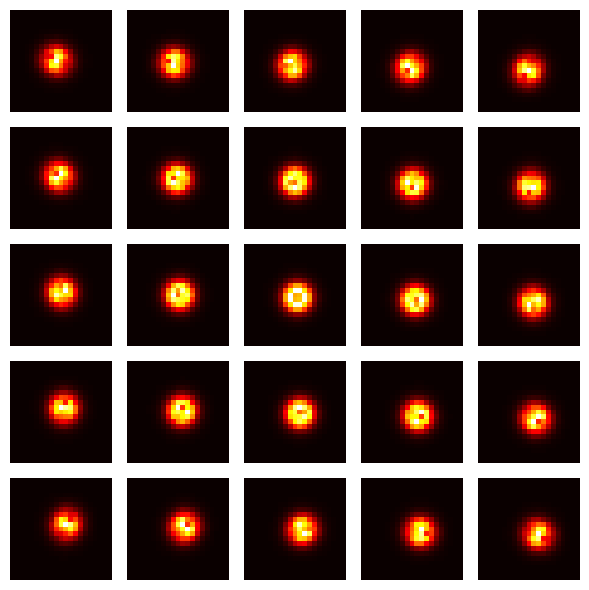

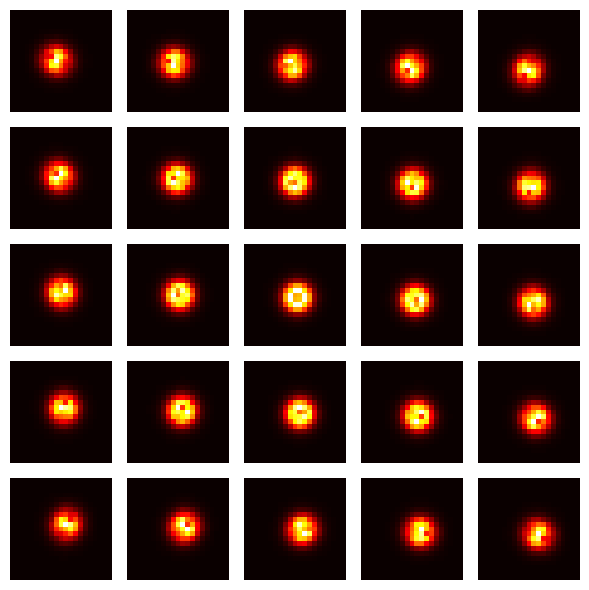

In [18]:
gr.ShowDataset(psf[0])    #[0,450:550,450:550]

C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\venv\Lib\site-packages\brighteyes_ism\analysis\Graph_lib.py:548: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(shift[:, 0], shift[:, 1], s=80, c=color, edgecolors='black', cmap=cmap)


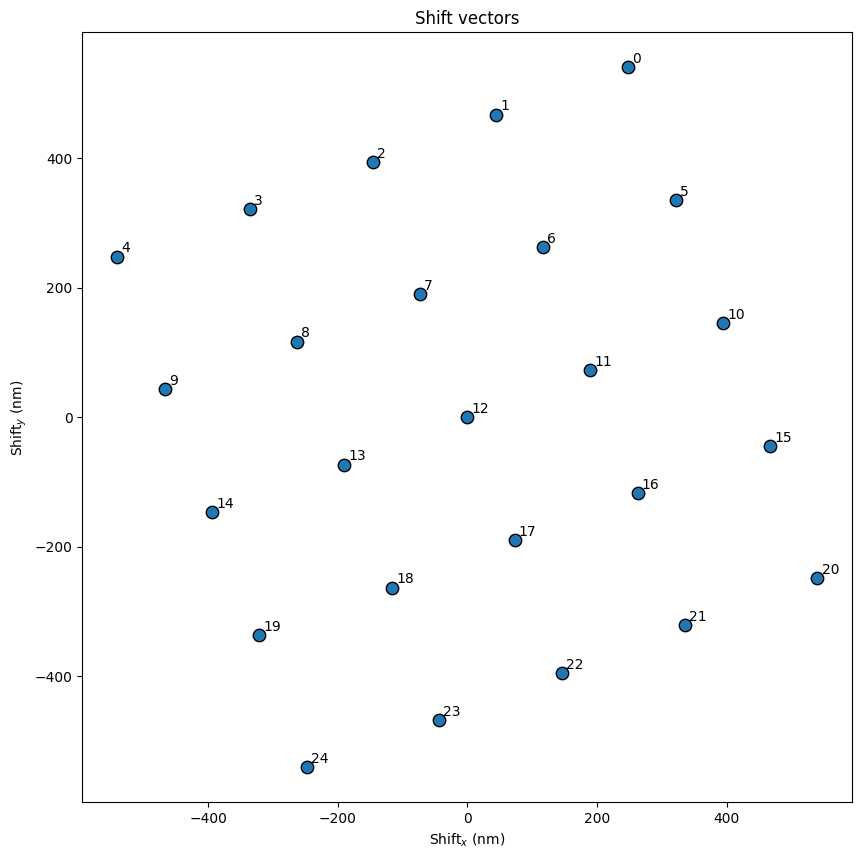

In [19]:
#shift_vectors_psf, _ = apr.ShiftVectors(psf[1], upsampling_factor, reference, filter_sigma=1)
#shift_vectors_psf *= pxs # we convert the shifts from pixels units to nm
#fig_3, ax_3 = plt.subplots(figsize = (10, 10))


#_ = gr.PlotShiftVectors(shift_vectors_psf, fig = fig_3, ax = ax_3)

In [20]:
#psf_down=tools.DownSample(psf, ds = ups, order = 'zxyc')

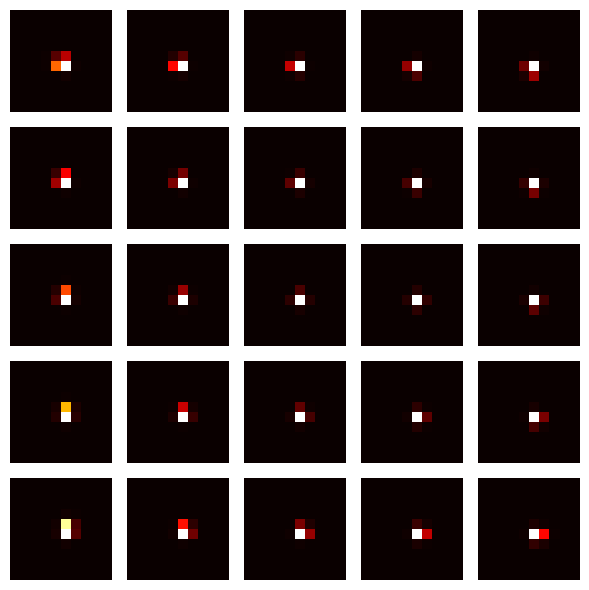

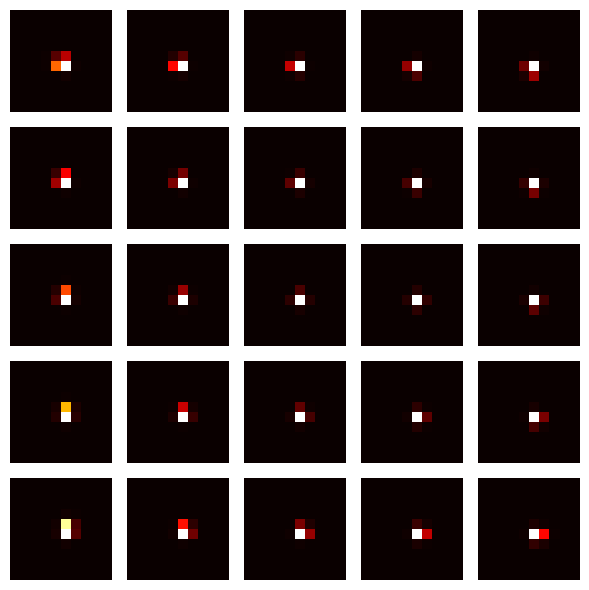

In [21]:
#gr.ShowDataset(psf_down[1,45:55,45:55])

In [19]:
def rect(t, w):
    r = np.where(abs(t) <= w/2, 1, 0)*1.
    r /= r.sum()
    return r

In [20]:
from skimage.filters import gaussian
def smooth_irf(t, s, w):
    irf_1 = rect(t, w)
    # g = gauss(t, 1, 0, t[len(t)//2], s)
    # irf_2 = convolve(irf_1, g, mode='same')
    dt = t[1] - t[0]
    irf_2 = gaussian(irf_1, s/dt)
    irf_2 /= irf_2.sum()
    return irf_2
 
 
# %%
dt = 48 * 1e-3  # ns
nbin = 260
window = 0.2  # ns
 
time = np.arange(nbin)*dt
 
t0 = time[len(time)//2]
# t0 = nbin*dt + 0
 

 
irf = smooth_irf(time - t0, dt, window)

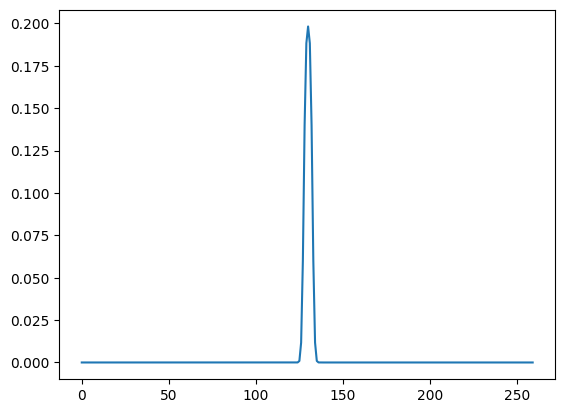

In [21]:
plt.figure()
plt.plot(irf)

In [22]:
print(emPar.airy_unit)

444.4285714285714


In [23]:
print(irf.shape)
print(psf.shape)

(260,)
(2, 21, 21, 25)


In [24]:
irf_1 = np.repeat(irf, 25).reshape((260,25))
print(irf_1.shape)

(260, 25)


In [26]:
psf_tot = est.combine_psf_irf(psf, irf_1)

In [29]:
print(psf_tot.shape)

(2, 100, 100, 260, 25)


In [29]:
#reconstruction = s2.max_likelihood_reconstruction(img[250:350, 25:125, :, :], psf_tot[:, 1:, 1:], stop='fixed', max_iter = 10)[0]   #[250:350, 25:125, :, :]
img_arr = np.asarray(img)
reconstruction = s2.batch_reconstruction(img_arr, psf_tot, (100,100), 20, stop='fixed',
                                         max_iter=10)

Batch 1/49


Progress: 11it [00:53,  4.90s/it]                                                                                                                                                                                                  


Batch 2/49


Progress: 11it [00:54,  4.93s/it]                                                                                                                                                                                                  


Batch 3/49


Progress: 11it [00:54,  4.99s/it]                                                                                                                                                                                                  


Batch 4/49


Progress: 11it [00:54,  4.92s/it]                                                                                                                                                                                                  


Batch 5/49


Progress: 11it [00:54,  4.92s/it]                                                                                                                                                                                                  


Batch 6/49


Progress: 11it [00:54,  4.92s/it]                                                                                                                                                                                                  


Batch 7/49


Progress: 11it [00:20,  1.88s/it]                                                                                                                                                                                                  


Batch 8/49


Progress: 11it [00:53,  4.91s/it]                                                                                                                                                                                                  


Batch 9/49


Progress: 11it [00:53,  4.89s/it]                                                                                                                                                                                                  


Batch 10/49


Progress: 11it [00:54,  4.98s/it]                                                                                                                                                                                                  


Batch 11/49


Progress: 11it [00:53,  4.90s/it]                                                                                                                                                                                                  


Batch 12/49


Progress: 11it [00:53,  4.91s/it]                                                                                                                                                                                                  


Batch 13/49


Progress: 11it [00:53,  4.90s/it]                                                                                                                                                                                                  


Batch 14/49


Progress: 11it [00:20,  1.87s/it]                                                                                                                                                                                                  


Batch 15/49


Progress: 11it [00:54,  4.95s/it]                                                                                                                                                                                                  


Batch 16/49


Progress: 11it [00:53,  4.88s/it]                                                                                                                                                                                                  


Batch 17/49


Progress: 11it [00:54,  4.94s/it]                                                                                                                                                                                                  


Batch 18/49


Progress: 11it [00:53,  4.88s/it]                                                                                                                                                                                                  


Batch 19/49


Progress: 11it [00:53,  4.89s/it]                                                                                                                                                                                                  


Batch 20/49


Progress: 11it [00:53,  4.87s/it]                                                                                                                                                                                                  


Batch 21/49


Progress: 11it [00:20,  1.87s/it]                                                                                                                                                                                                  


Batch 22/49


Progress: 11it [00:53,  4.88s/it]                                                                                                                                                                                                  


Batch 23/49


Progress: 11it [00:53,  4.88s/it]                                                                                                                                                                                                  


Batch 24/49


Progress: 11it [00:53,  4.86s/it]                                                                                                                                                                                                  


Batch 25/49


Progress: 11it [00:53,  4.90s/it]                                                                                                                                                                                                  


Batch 26/49


Progress: 11it [00:54,  4.98s/it]                                                                                                                                                                                                  


Batch 27/49


Progress: 11it [00:54,  4.95s/it]                                                                                                                                                                                                  


Batch 28/49


Progress: 11it [00:20,  1.88s/it]                                                                                                                                                                                                  


Batch 29/49


Progress: 11it [00:54,  4.93s/it]                                                                                                                                                                                                  


Batch 30/49


Progress: 11it [00:53,  4.88s/it]                                                                                                                                                                                                  


Batch 31/49


Progress: 11it [00:53,  4.84s/it]                                                                                                                                                                                                  


Batch 32/49


Progress: 11it [00:53,  4.86s/it]                                                                                                                                                                                                  


Batch 33/49


Progress: 11it [00:53,  4.85s/it]                                                                                                                                                                                                  


Batch 34/49


Progress: 11it [00:53,  4.88s/it]                                                                                                                                                                                                  


Batch 35/49


Progress: 11it [00:20,  1.86s/it]                                                                                                                                                                                                  


Batch 36/49


Progress: 11it [00:53,  4.85s/it]                                                                                                                                                                                                  


Batch 37/49


Progress: 11it [00:53,  4.87s/it]                                                                                                                                                                                                  


Batch 38/49


Progress: 11it [00:53,  4.86s/it]                                                                                                                                                                                                  


Batch 39/49


Progress: 11it [00:53,  4.85s/it]                                                                                                                                                                                                  


Batch 40/49


Progress: 11it [00:53,  4.85s/it]                                                                                                                                                                                                  


Batch 41/49


Progress: 11it [00:53,  4.89s/it]                                                                                                                                                                                                  


Batch 42/49


Progress: 11it [00:20,  1.88s/it]                                                                                                                                                                                                  


Batch 43/49


Progress: 11it [00:21,  1.92s/it]                                                                                                                                                                                                  


Batch 44/49


Progress: 11it [00:21,  1.92s/it]                                                                                                                                                                                                  


Batch 45/49


Progress: 11it [00:21,  1.93s/it]                                                                                                                                                                                                  


Batch 46/49


Progress: 11it [00:21,  2.00s/it]                                                                                                                                                                                                  


Batch 47/49


Progress: 11it [00:21,  1.99s/it]                                                                                                                                                                                                  


Batch 48/49


Progress: 11it [00:21,  1.97s/it]                                                                                                                                                                                                  


Batch 49/49


Progress: 11it [00:08,  1.34it/s]                                                                                                                                                                                                  


In [30]:
print(reconstruction[0].shape)

(512, 512, 260)


(<Figure size 640x480 with 2 Axes>, <Axes: >)

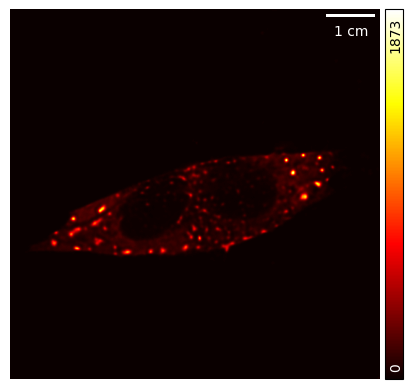

In [31]:
reconstruction_t_sum = np.sum(reconstruction, axis=(-1))
gr.ShowImg(reconstruction_t_sum[0], pxs)

(<Figure size 640x480 with 2 Axes>, <Axes: >)

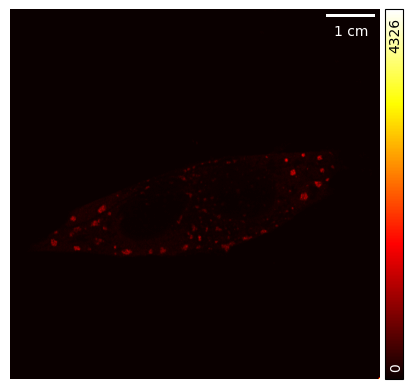

In [32]:
gr.ShowImg(reconstruction_t_sum[1], pxs)

In [34]:
img_s = np.sum(img, axis=(-2, -1))
print(img_s)


[[0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 4.0000e+00 8.0000e+00 ... 4.0000e+00 9.0000e+00 1.1000e+01]
 [0.0000e+00 2.0000e+00 5.0000e+00 ... 1.0000e+00 7.0000e+00 1.0000e+01]
 ...
 [0.0000e+00 3.0000e+00 2.0000e+00 ... 4.0000e+00 7.0000e+00 1.0000e+01]
 [0.0000e+00 4.0000e+00 4.0000e+00 ... 6.0000e+00 1.0000e+00 1.4000e+01]
 [0.0000e+00 1.4000e+01 8.0000e+00 ... 6.0000e+00 1.1000e+01 1.2117e+04]]


(<Figure size 640x480 with 2 Axes>, <Axes: >)

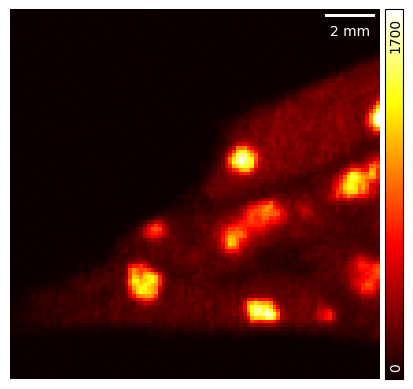

In [35]:
gr.ShowImg(img_s[250:350, 25:125], pxs)

### Lifetime analysis

In [33]:
data_intensity = np.sum(reconstruction[0], axis=(-1)) #data intensity out of focus
print(data_intensity.shape)

(512, 512)


In [34]:
phasors_pix = flim.phasor(reconstruction[1]) 

C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\src\brighteyes_flim\flism.py:350: RuntimeWarning: invalid value encountered in divide
  return np.where(flux < threshold, np.nan + 1j * np.nan, transform / flux)


In [40]:
data_intensity_in_focus = np.sum(reconstruction[1], axis=(-1))

### Raw phasor plot of in focus reconstruction

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='g', ylabel='s'>)

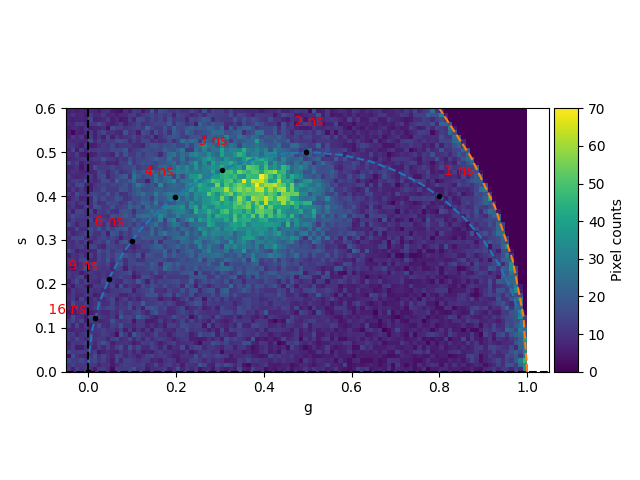

In [35]:
%matplotlib widget
flim.plot_phasor(phasors_pix[:], bins_2dplot=200, log_scale=False, quadrant='first', dfd_freq = 80e6)

In [36]:
phasors_pix_out_of_focus = flim.phasor(reconstruction[0]) 

### Raw phasor plot of out of focus reconstruction

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='g', ylabel='s'>)

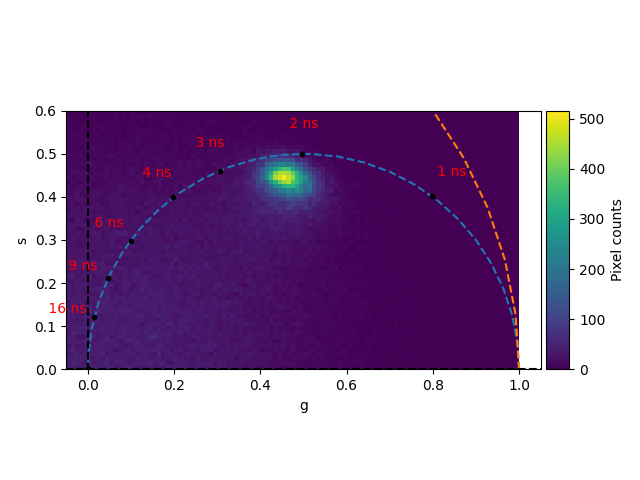

In [37]:
%matplotlib widget
flim.plot_phasor(phasors_pix_out_of_focus[:], bins_2dplot=200, log_scale=False, quadrant='first', dfd_freq = 80e6)

### Intensity-based thresholded Phasor plot of in focus reconstruction 

(410,)


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='g', ylabel='s'>)

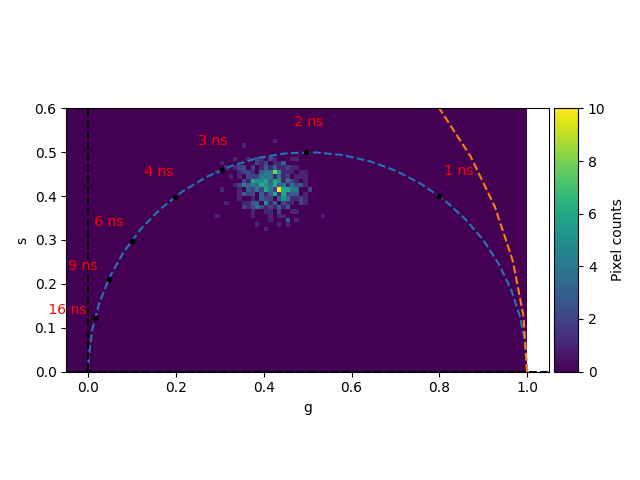

In [49]:
phasors_pix_thresholded = flim.threshold_phasor(data_intensity_in_focus, phasors_pix, threshold = 0.15)
print(phasors_pix_thresholded.shape)
flim.plot_phasor(phasors_pix_thresholded[:], bins_2dplot=200, log_scale=False, quadrant='first', dfd_freq = 80e6)

### Intensity-based thresholded Phasor plot of out focus reconstruction 

(1961,)


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='g', ylabel='s'>)

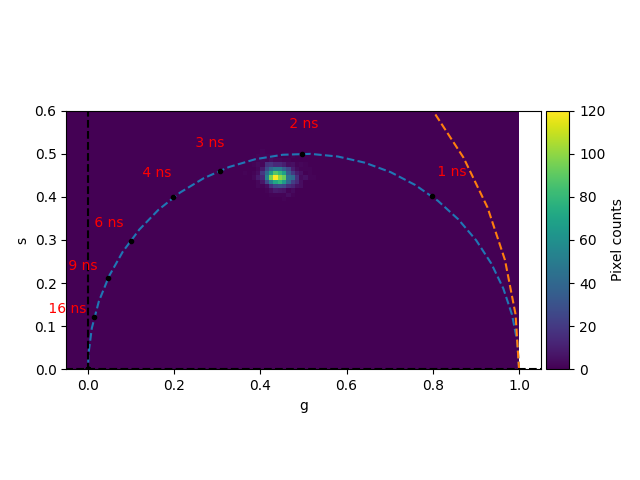

In [44]:
phasors_pix_thresholded_out_of_focus = flim.threshold_phasor(data_intensity, phasors_pix_out_of_focus, threshold = 0.15)
print(phasors_pix_thresholded_out_of_focus.shape)
flim.plot_phasor(phasors_pix_thresholded_out_of_focus[:], bins_2dplot=200, log_scale=False, quadrant='first', dfd_freq = 80e6)

### In focus phasor plot after applying median filter on pixels' phasor (window 3x3)

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='g', ylabel='s'>)

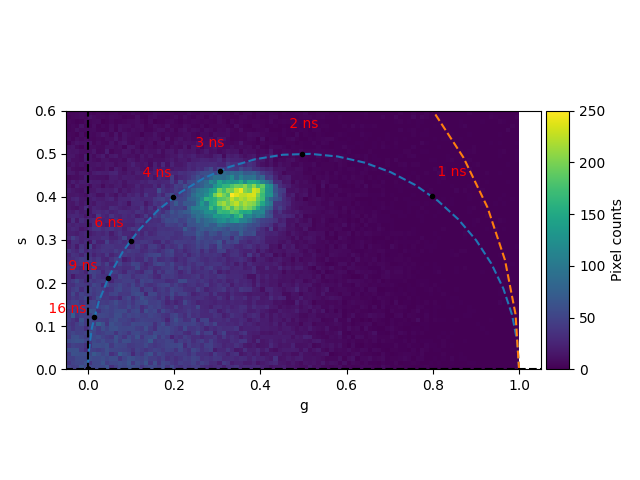

In [45]:
phasors_pix_median = flim.median_phasors(phasors_pix, window=3)
flim.plot_phasor(phasors_pix_median[:], bins_2dplot=200, log_scale=False, quadrant='first', dfd_freq = 80e6)

### Out of focus phasor plot after applying median filter on pixels' phasor (window 3x3)

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='g', ylabel='s'>)

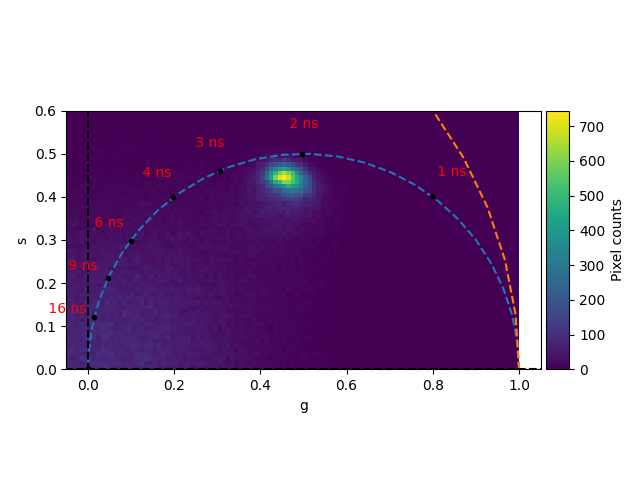

In [46]:
phasors_pix_median = flim.median_phasors(phasors_pix_out_of_focus, window=3)
flim.plot_phasor(phasors_pix_median[:], bins_2dplot=200, log_scale=False, quadrant='first', dfd_freq = 80e6)

In [53]:
tau_m_out = flim.calculate_tau_m(np.real(phasors_pix_thresholded_out_of_focus), np.imag(phasors_pix_thresholded_out_of_focus), dfd_freq = 80e6)
print(tau_m_out.shape)

(1961,)


### Lifetime histogram of out of focus image

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 2.760e+02, 1.526e+03, 1.580e+02, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00]),
 array([ 0.  ,  0.26,  0.52,  0.78,  1.04,  1.3 ,  1.56,  1.82,  2.08,
         2.34,  2.6 ,  2.86,  3.12,  3.38,  3.64,  3.9 ,  4.16,  4.42,
         4.68,  4.94,  5.2 ,  5.46,  5.72,  5.98,  6.24,  6.5 ,  6.76,
         7.02,  7.28,  7.54,  7.8 ,  8.06,  8.32,  8.58,  8.84,  9.1 ,
         9.36,  9.62,  9.88, 10.14, 10.4 , 10.66, 10.92, 11.18, 11.44,
        11.7 , 11.96,

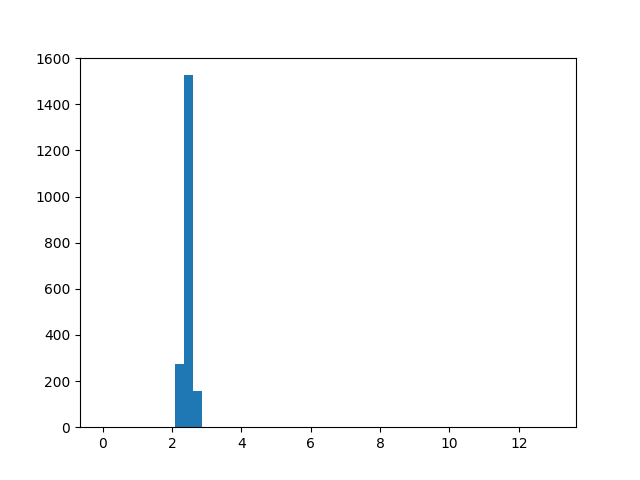

In [54]:
tau_m_data = 1e9*tau_m_out.flatten()

plt.figure()
plt.hist(tau_m_data, range = (0, 13), bins = 50)

### Lifetime histogram of in focus image

In [55]:
tau_m_in = flim.calculate_tau_m(np.real(phasors_pix_thresholded), np.imag(phasors_pix_thresholded), dfd_freq = 80e6)
print(tau_m_in.shape)

(410,)


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  20., 126., 155.,
         80.,  23.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 0.  ,  0.26,  0.52,  0.78,  1.04,  1.3 ,  1.56,  1.82,  2.08,
         2.34,  2.6 ,  2.86,  3.12,  3.38,  3.64,  3.9 ,  4.16,  4.42,
         4.68,  4.94,  5.2 ,  5.46,  5.72,  5.98,  6.24,  6.5 ,  6.76,
         7.02,  7.28,  7.54,  7.8 ,  8.06,  8.32,  8.58,  8.84,  9.1 ,
         9.36,  9.62,  9.88, 10.14, 10.4 , 10.66, 10.92, 11.18, 11.44,
        11.7 , 11.96, 12.22, 12.48, 12.74, 13.  ]),
 <BarContainer object of 50 artists>)

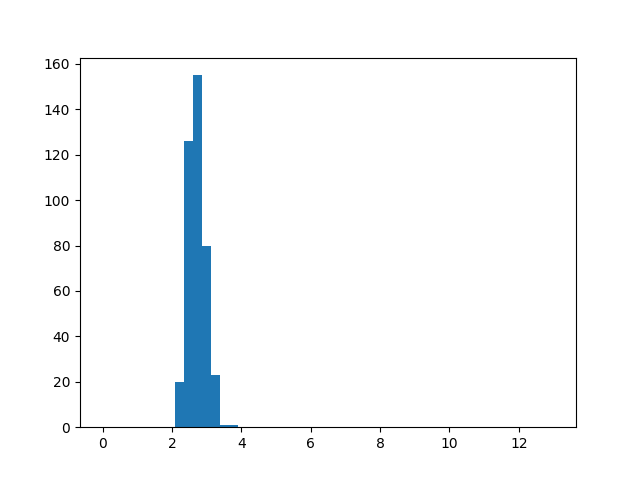

In [56]:
tau_m_data_in = 1e9*tau_m_in.flatten()

plt.figure()
plt.hist(tau_m_data_in, range = (0, 13), bins = 50)